In [1]:
# probably won't need all of this stuff, but why not import it all?

import SD_raster_loading
import SD_NC_loading
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dalecLoad
import spectralConv

In [2]:
SD_directory = 'C:/Users/daa5/\
OneDrive - University of Stirling/\
PlanetData/\
Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/\
acolite_output/'

file = 'PlanetScope_227a_2022_08_13_11_13_41_L2R.nc' # from 13th Aug, which corresponds to DALEC log 87

f = netCDF4.Dataset(SD_directory+file)
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    generated_by: ACOLITE
    generated_on: 2022-08-24 10:58:27 GMT Summer Time
    contact: Quinten Vanhellemont
    product_type: NetCDF
    metadata_profile: beam
    metadata_version: 0.5
    auto_grouping: rhot:rhorc:rhos:rhow:Rrs
    Conventions: CF-1.7
    sensor: PlanetScope_SD8
    satellite_sensor: PlanetScope_227a
    isodate: 2022-08-13T11:13:41+00:00
    sza: 43.67708
    vza: 4.941244
    raa: 139.06694
    se_distance: 1.0132199756116838
    mus: 0.7232434613772802
    acolite_file_type: L2R
    oname: PlanetScope_227a_2022_08_13_11_13_41
    ofile: C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey_8-20Aug-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_227a_2022_08_13_11_13_41_L2R.nc
    Coastal-Blue_wave: 443.6610607244119
    Coastal-Blue_name: 444
    Coastal-Blue_f0: 19014.80145243501
    Blue_wave: 492.3012651262192
    Blue_name: 492
    Blue_f0: 19688.

In [3]:
print(f.variables.keys()) # get all variable names

dict_keys(['transverse_mercator', 'x', 'y', 'lon', 'lat', 'rhot_444', 'rhos_444', 'rhot_492', 'rhos_492', 'rhot_533', 'rhos_533', 'rhot_566', 'rhos_566', 'rhot_612', 'rhos_612', 'rhot_666', 'rhos_666', 'rhot_707', 'rhos_707', 'rhot_866', 'rhos_866'])


In [4]:
coord = [56.14693897799395, -3.923458784671348] # this is approx the location of the DALEC
coord2 = [56.146746528609306, -3.92285731543299] # this is perhaps a deeper part of the loch

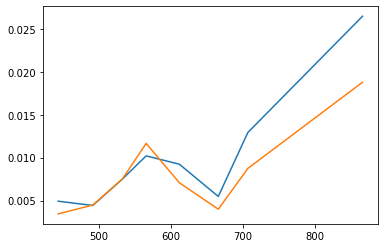

In [5]:
SD_spect1 = SD_NC_loading.get_SD_NC_Spectra(f, coord[0], coord[1])
SD_spect2 = SD_NC_loading.get_SD_NC_Spectra(f, coord2[0], coord2[1])           

plt.plot(SD_spect1['Wavelength'], SD_spect1['Rho_s']/np.pi)
plt.plot(SD_spect2['Wavelength'], SD_spect2['Rho_s']/np.pi)
plt.show()

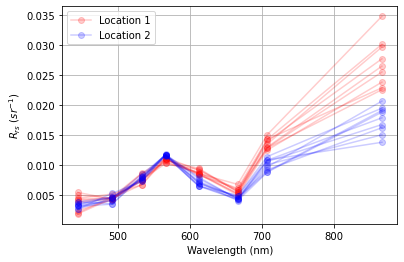

In [6]:
# let's load a 3x3 grid of pixels
SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3)) 
SD_spect2 = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord2[0], coord2[1], shape=(3, 3)) 



fig, ax = plt.subplots()

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='Location 2',
            marker='o',
            alpha=0.2)
    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')


# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

for more flexibility and handling of multiple days its better to use resampleMultiLog() followed by uniform_grid_spectra_multi()


KeyError: ' UTC Date'

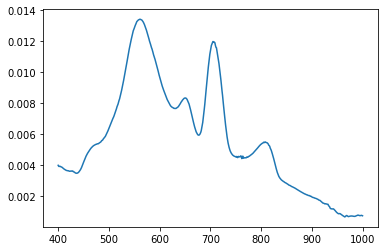

In [7]:
# let's check out the corresponding log file!
filepath = 'data/Jul-Aug/LOG_0087.dtf'
log87 = dalecLoad.load_DALEC_log(filepath)
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths(filepath)
mean_spect = dalecLoad.uniform_grid_spectra_mean(log87, spect_wavelengths)

fig, ax = plt.subplots()

ax.plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'])
ax.set_title(str(log87[' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol
ax.set_ylim(0, 0.018)
ax.set_ylabel('$R_{rs}$')
ax.set_xlabel('Wavelength (nm)')       

plt.show()

In [ ]:
log87.loc[:, 'Lsky', :]['Spectral Magnitude']

In [ ]:
# and plot together: LOOKS ALRIGHT...

fig, ax = plt.subplots()

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SD Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='SD Location 2',
            marker='o',
            alpha=0.2)
    

df_summary = dalecLoad.uniform_grid_spectra_stats(log87, spect_wavelengths, percentiles=[.05, .25, .5, .75, .95])

ax.fill_between(df_summary['wavelength'], df_summary['5%'], y2=df_summary['95%'],
                   color='gray', alpha=0.25, label='DALEC: 5-95 percentile')


ax.plot(df_summary['wavelength'], df_summary['mean'], label='DALEC: mean')
    
#ax.plot(mean_spect['Wavelength'], mean_spect['Rrs_mean'], label='DALEC mean')
ax.set_title(str(log87[' UTC Date'].iloc[0])[:10]) # using [:10] as a hacky way to not print the time lol

    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')


# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

In [ ]:
# now let's see what happens when we do the convolution on the DALEC data

RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')
DALEC_SD = spectralConv.SD_band_calc(RSR_doves, mean_spect['Rrs_mean'].values,
                                     RSR_doves['Wavelength (nm)'].values)


fig, ax = plt.subplots()

ax.plot(SD_spect['Wavelength'], DALEC_SD, label='DALEC')

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SD Location 1',
             marker='o',
             alpha=0.2)

for col in list(SD_spect2.columns.values)[1:]:
    ax.plot(SD_spect2['Wavelength'],
            SD_spect2[col]/np.pi,
            color='blue',
            label='SD Location 2',
            marker='o',
            alpha=0.2)
    

    
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')
    
# this code removes duplicate labels in the legend. Naughty
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)

ax.grid()
plt.show()

In [ ]:
# now gonna try to look at all SD files:
import os
SD_files = []
for file in os.listdir(SD_directory):
    if file.endswith("L2R.nc"):
        SD_files.append(os.path.join(SD_directory, file))
SD_files

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(25, 12))

ax = ax.flatten()

for i in range(len(SD_files)):
    f = netCDF4.Dataset(SD_files[i])
    SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3)) 
    
    for col in list(SD_spect.columns.values)[1:]:
        ax[i].plot(SD_spect['Wavelength'],
                 SD_spect[col]/np.pi,
                 color='red',
                 label='Location 1',
                 marker='o',
                 alpha=0.2)
    
    ax[i].set_title(SD_files[i][-26:]) # note that currently files aren't in the right order... this is annoying!
plt.show()

In [ ]:
# so it's pretty easy to get the datetime from the loaded ncdf file:
# just need to think of some nice way to load in the data so that it has the date attached to it
pd.to_datetime(f.isodate)

In [ ]:
# should really use list comprehensions a bit more but this works for now
ncdf_dates = []
indexes = []
SD_spect_list = []

for i in range(len(SD_files)):
    f = netCDF4.Dataset(SD_files[i])
    SD_spect = SD_NC_loading.get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3))
    ncdf_dates.append(f.isodate)
    indexes.append(i)
    SD_spect_list.append(SD_spect)

In [ ]:
print(ncdf_dates)
print(indexes)
print(sorted(ncdf_dates))

In [ ]:
# some naughty sorting code

indexes_sorted = [x for _, x in sorted(zip(ncdf_dates, indexes))]
indexes_sorted

In [ ]:
# now plot the SD files in the right order!

SD_spect_list_sorted = [x for _, x in sorted(zip(ncdf_dates, SD_spect_list))]
sorted_dates = sorted(ncdf_dates)

fig, ax = plt.subplots(2, 4, figsize=(25, 12))
ax = ax.flatten()

for i in range(len(SD_files)):
    SD_spect = SD_spect_list_sorted[i]
    date = sorted_dates[i]
    
    for col in list(SD_spect.columns.values)[1:]:
        ax[i].plot(SD_spect['Wavelength'],
                 SD_spect[col]/np.pi,
                 color='red',
                 label='Location 1',
                 marker='o',
                 alpha=0.2)
        
    
    ax[i].set_title(str(date)[:19])
    ax[i].set_ylim([0, 0.025])
plt.show()

In [ ]:
SD_spect

In [ ]:
# now I'm going to see if I can make a nice dataframe which includes datetime...

SD_df = SD_spect.copy()
SD_df['Date'] = pd.to_datetime(date)
SD_df['Date'] = SD_df['Date'].dt.date # just removes the time aspect from the variable
SD_df.set_index(['Date', 'Wavelength'], inplace=True)
SD_df.index
SD_df

In [ ]:
DALEC_df = pd.DataFrame(data=DALEC_SD, columns=['DALEC_mean_Rrs'])
DALEC_df['Date'] = pd.to_datetime(date)
DALEC_df['Date'] = DALEC_df['Date'].dt.date # just removes the time aspect from the variable
DALEC_df['Wavelength'] = SD_spect['Wavelength']
DALEC_df.set_index(['Date', 'Wavelength'], inplace=True)
DALEC_df.index
DALEC_df

In [ ]:
DALEC_df

In [ ]:
DALEC_df.join(SD_df, on=['Date', 'Wavelength'])

In [ ]:
# kinda hacky but probably fine

DALEC_df = None # just initialise as None so as not to start getting weird things happening if I run this multiple times

for i in range(8):
    filepath = 'data/Jul-Aug/LOG_00' + str(82 + i) + '.dtf'
    print('loading ... ' + str(filepath))
    dalec_log = dalecLoad.load_DALEC_log(filepath)
    mean_spect = dalecLoad.uniform_grid_spectra_mean(dalec_log, spect_wavelengths)
    DALEC_SD = spectralConv.SD_band_calc(RSR_doves, mean_spect['Rrs_mean'].values,
                                         RSR_doves['Wavelength (nm)'].values)
    DALEC_df_tmp = pd.DataFrame(data=DALEC_SD, columns=['DALEC_mean_Rrs'])
    DALEC_df_tmp['Date'] = pd.to_datetime(dalec_log[' UTC Date'].iloc[0])
    DALEC_df_tmp['Date'] = DALEC_df_tmp['Date'].dt.date # just removes the time aspect from the variable
    DALEC_df_tmp['Wavelength'] = SD_spect['Wavelength']
    DALEC_df_tmp.set_index(['Date', 'Wavelength'], inplace=True)
    if DALEC_df is None:
        DALEC_df = DALEC_df_tmp.copy()
    else:
        DALEC_df = pd.concat([DALEC_df, DALEC_df_tmp])
        
DALEC_df



In [ ]:
SD_df = None

for i in range(len(SD_spect_list_sorted)):
    SD_spect = SD_spect_list_sorted[i]
    date = sorted_dates[i]
    if date[:10] != sorted_dates[i-1][:10]: # can't be bothered to deal with multiple images from same day right now
        SD_df_tmp = SD_spect.copy()
        SD_df_tmp['Date'] = pd.to_datetime(date)
        SD_df_tmp['Date'] = SD_df_tmp['Date'].dt.date # just removes the time aspect from the variable
        SD_df_tmp.set_index(['Date', 'Wavelength'], inplace=True)
        if SD_df is None:
            SD_df = SD_df_tmp.copy()
        else:
            SD_df = pd.concat([SD_df, SD_df_tmp])
    else:
        print('skipping duplicate date entry')
SD_df

In [ ]:
# okay so now we can join our DFs together and plot match ups

superDuperDF = DALEC_df.join(SD_df, on=['Date', 'Wavelength']).dropna() 
# drop NA means we're just left with dates where we have both DALEC and SD measurements

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(25, 7))

for i, date in zip(range(3), superDuperDF.index.get_level_values(0).unique()):
    x = superDuperDF.index.get_level_values(1).unique()
    y = superDuperDF.loc[[date]]['DALEC_mean_Rrs'].values
    ax[i].plot(x, y, label='DALEC Mean')
    for col in list(superDuperDF.columns.values)[1:]:
        y = superDuperDF.loc[[date]][col].values/np.pi
        ax[i].plot(x, y,
                   color='red',
                   label='SuperDoves @ DALEC loc.',
                   marker='o',
                   alpha=0.2)
    ax[i].set_ylim([0, 0.03])
    ax[i].set_title(str(date))
    
    ax[i].set_xlabel('Wavelength (nm)')
    ax[i].set_ylabel('$R_{rs}$ $(sr^{-1}$)')


    # this code removes duplicate labels in the legend. Naughty
    handles, labels = ax[i].get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    ax[i].legend(newHandles, newLabels)

    ax[i].grid()
plt.show()

## Phycoyanin indicator over time

3 days isn't enough data, but we can see that the SD data is too noisy to detect the trend which we see in the DALEC data.

Might be worth repeating this plot at the deeper location, as this hopefully suffers less from adjacency effects and so I hope that the changes in the 707 nm band might be better captured.

In [ ]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

DALEC_612 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],612.0), :]['DALEC_mean_Rrs'].values
DALEC_707 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],707.0), :]['DALEC_mean_Rrs'].values

DALEC_612_707 = DALEC_707/DALEC_612

x = superDuperDF.index.get_level_values(0).unique() # x is the list of dates

plt.plot(x, DALEC_612_707)


for col in list(superDuperDF.columns.values)[1:]:
    SD_612 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],612.0), :][col].values
    SD_707 = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],707.0), :][col].values

    SD_612_707 = SD_707/SD_612
    plt.plot(x, SD_612_707,
               color='red',
               label='SuperDoves @ DALEC loc.',
               marker='o',
               alpha=0.2)
    
plt.xticks(rotation = 45)
plt.xlabel('Date (DD-MMM)')
plt.ylabel('$R_{rs}[710]$ / $R_{rs}[620]$')

ax = plt.gca()
date_form = DateFormatter("%d-%b") # DD-MMM format
ax.xaxis.set_major_formatter(date_form) # set format
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) # make sure that ticks only appear daily
plt.show()

### Match Up Plots (SD vs DALEC)

3 superdoves images isn't really enough for a good DALEC-SD comparison, but here is some code to generate nice comparison plots for each waveband. 

Can already see that we have a lot of variation, but for most wavebands, we aren't too far from the x-y line. 

In [ ]:
fig, ax = plt.subplots(2, 4, figsize=(25, 12))

ax = ax.flatten()

for i, wavelength in zip(range(8), superDuperDF.index.get_level_values(1).unique()):
    x = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],wavelength), :]['DALEC_mean_Rrs'].values
    #ax[i].scatter(x, y, label='DALEC Mean')
    for col in list(superDuperDF.columns.values)[1:]:
        y = superDuperDF.loc[(superDuperDF.index.get_level_values(0)[:],wavelength), :][col].values/np.pi
        ax[i].scatter(x, y,
                      color='red',
                      marker='o',
                      alpha=0.2)
    #ax[i].set_ylim([0, 0.03])
    ax[i].set_title('$\lambda = $' + str(wavelength) + ' nm')
    
    ax[i].set_xlabel('DALEC')
    ax[i].set_ylabel('SD')

    ax[i].grid()
    
    max_xy = np.max([x, y])
    
    ax[i].set_ylim([0, max_xy*1.2])
    ax[i].set_xlim([0, max_xy*1.2])
    #plt.axis('equal')
    ax[i].set_aspect('equal', adjustable='box')
    #ax[i].set_aspect('equal', adjustable='datalim', anchor='C')
    ax[i].plot([0, 1], [0, 1], 'k--', alpha=0.5)


plt.show()

In [ ]:
print(np.max([x, y])//)
print([x, y])

In [ ]:
superDuperDF.index.get_level_values(1)

In [ ]:
superDuperDF.index.get_level_values(0).unique()

In [ ]:
superDuperDF.columns.values